## 라이브러리 설치

In [121]:
import random
# 데이터 플로팅 라이브러리
import matplotlib.pyplot as plt
# 숫자 처리 라이브러리
import numpy as np
# 딥러닝을 위한 파이토치 라이브러리
import torch
from torch import nn, optim
# 토치비전 라이브러리
import torchvision
from torchvision import datasets, transforms, models
# 이미지 처리 라이브러리 (PIL, pillow)
from PIL import Image
# 주피터 노트북에서 plot이 보이도록 설정
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 데이터 디렉토리, 분할 비율 변환 방법을 설정

In [122]:
#이미지 데이터가 있는 디렉토리와 데이터 세트 분할 비율(valid_size)을 정한다.
import torch.backends


data_dir = './data'
valid_size = 0.2
seed = 42

#이미지 데이터를 ResNet50에서 다룰 수 있도록 변환시키는 방법을 정한다. (t_transforms)
t_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.Resize(224),
    transforms.ToTensor()
])

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
""" print(t_transforms) """

' print(t_transforms) '

### (확인) 변환방법 출력

In [35]:
print(t_transforms)

Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
)


## 데이터 로더 함수 작성
### 1. trainloader와 testloader 생성

In [119]:
# datasets.ImageFolder를 사용해서 학습데이터와 테스트 데이터를 만든다.
train_data = datasets.ImageFolder(data_dir, transform=t_transforms)
test_data = datasets.ImageFolder(data_dir, transform=t_transforms)

# 학습 데이터의 형식 확인
print("train_data : ",train_data)

# 학습 데이터와 테스트 데이터의 길이를 확인
print('길이 확인 \n train_data : ',len(train_data), "\n test data : ", len(test_data))

train_data :  Dataset ImageFolder
    Number of datapoints: 155
    Root location: ./data
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
길이 확인 
 train_data :  155 
 test data :  155


### 2.데이터 세트를 섞기위해, 인덱스 만들어 랜덤하게 섞음

In [123]:
# train_data 사이즈만큼의 정수값을 갖는 인덱스 리스트(indices)를 만들고 확인
num_train = len(train_data)
indices = list(range(num_train))
print(indices)

# 인덱스 리스트를 랜덤하게 섞고 확인한다.
np.random.shuffle(indices)
print(indices)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154]
[81, 142, 31, 29, 118, 60, 93, 147, 153, 68, 42, 138, 78, 75, 15, 19, 30, 90, 117, 137, 18, 12, 9, 24, 69, 131, 95, 45, 86, 84, 126, 96, 122, 82, 109, 65, 51, 26, 133, 76, 56, 36, 124, 22, 55, 85, 11, 141, 66, 119, 27, 79, 144, 41, 4, 32, 134, 143, 67, 16, 123, 10, 113, 146, 101, 0, 110, 64, 44, 97, 28, 40, 104, 25, 23, 108, 39, 151

### 3.분할 비율(valid_size)에 따른 지점의 인덱스 값(split)을 계산

In [38]:
# 분할 비율(valid_size)에 해당하는 인덱스를 계산하고 확인해 본다.
split = int(np.floor(num_train * valid_size))
print(split)

31


### 4.split을 기준으로 학습 데이터 인덱스 리스트와 데스트 인덱스 리스트로 나눈다.

In [39]:
# 학습 데이터 인덱스 리스트 및 데스트 인덱스 리스트를 만들고 확인해 본다.
train_idx, test_idx = indices[split:], indices[:split]

print(train_idx)
print(test_idx)

[96, 122, 82, 109, 65, 51, 26, 133, 76, 56, 36, 124, 22, 55, 85, 11, 141, 66, 119, 27, 79, 144, 41, 4, 32, 134, 143, 67, 16, 123, 10, 113, 146, 101, 0, 110, 64, 44, 97, 28, 40, 104, 25, 23, 108, 39, 151, 98, 150, 136, 47, 111, 61, 73, 33, 148, 125, 62, 105, 94, 53, 5, 127, 114, 49, 35, 80, 77, 34, 46, 7, 43, 70, 112, 91, 83, 139, 140, 89, 8, 13, 59, 132, 3, 17, 38, 72, 135, 6, 128, 100, 2, 120, 63, 115, 54, 107, 50, 152, 58, 48, 88, 21, 57, 149, 129, 37, 145, 1, 52, 130, 103, 99, 116, 87, 74, 121, 154, 20, 71, 106, 14, 92, 102]
[81, 142, 31, 29, 118, 60, 93, 147, 153, 68, 42, 138, 78, 75, 15, 19, 30, 90, 117, 137, 18, 12, 9, 24, 69, 131, 95, 45, 86, 84, 126]


### 5.데이터 세트들의 샘플러 및 로더를 만들고 확인

In [125]:
# 데이터 샘플링 방식(SubsetRandomSampler)을 지정
from torch.utils.data.sampler import SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

print('train_sampler.indices : ', train_sampler.indices);
print('test_sampler.indices : ', test_sampler.indices);

# 데이터 로딩을 위한 loader 생성 (sampler, 배치 사이즈 등 지정)
trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size = 16)
testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size = 16)

# 학습 loader와 데스트 loader의 class들을 출력하여 확인한다.
print(trainloader.dataset.classes)
print(testloader.dataset.classes)

train_sampler.indices :  [96, 122, 82, 109, 65, 51, 26, 133, 76, 56, 36, 124, 22, 55, 85, 11, 141, 66, 119, 27, 79, 144, 41, 4, 32, 134, 143, 67, 16, 123, 10, 113, 146, 101, 0, 110, 64, 44, 97, 28, 40, 104, 25, 23, 108, 39, 151, 98, 150, 136, 47, 111, 61, 73, 33, 148, 125, 62, 105, 94, 53, 5, 127, 114, 49, 35, 80, 77, 34, 46, 7, 43, 70, 112, 91, 83, 139, 140, 89, 8, 13, 59, 132, 3, 17, 38, 72, 135, 6, 128, 100, 2, 120, 63, 115, 54, 107, 50, 152, 58, 48, 88, 21, 57, 149, 129, 37, 145, 1, 52, 130, 103, 99, 116, 87, 74, 121, 154, 20, 71, 106, 14, 92, 102]
test_sampler.indices :  [81, 142, 31, 29, 118, 60, 93, 147, 153, 68, 42, 138, 78, 75, 15, 19, 30, 90, 117, 137, 18, 12, 9, 24, 69, 131, 95, 45, 86, 84, 126]
['Basalt', 'Highland']
['Basalt', 'Highland']


## 코드들을 묶어서 load_split_train_test() 함수 생성

In [126]:
# 위의 코드들을 묶어서 load_split_train_test() 함수를 만든다. (입력 : 데이터 디렉토리, 분할 비율) (출력 : 학습 데이터 로더, 테스트 데이터 로더)

def load_split_train_test(data_dir, valid_size) :
    t_transforms = transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.Resize(224),
                transforms.ToTensor()
    ])
    
    train_data = datasets.ImageFolder(data_dir, transform=t_transforms)
    test_data = datasets.ImageFolder(data_dir, transform=t_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))

    np.random.shuffle(indices)
    split = int(np.floor(num_train * valid_size))
    train_idx, test_idx = indices[split:], indices[:split]
    from torch.utils.data.sampler import SubsetRandomSampler

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=16)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=16)

    return trainloader, testloader

## load_split_train_test() 함수 사용

In [128]:
# load_split_train_test() 함수를 이용하여 trainloader와 testloader를 만들고 확인한다.
trainloader, testloader = load_split_train_test(data_dir, 0.2)

print(trainloader.dataset.classes)
print(testloader.dataset.classes)

['Basalt', 'Highland']
['Basalt', 'Highland']


## 이미지 데이터 샘플 확인

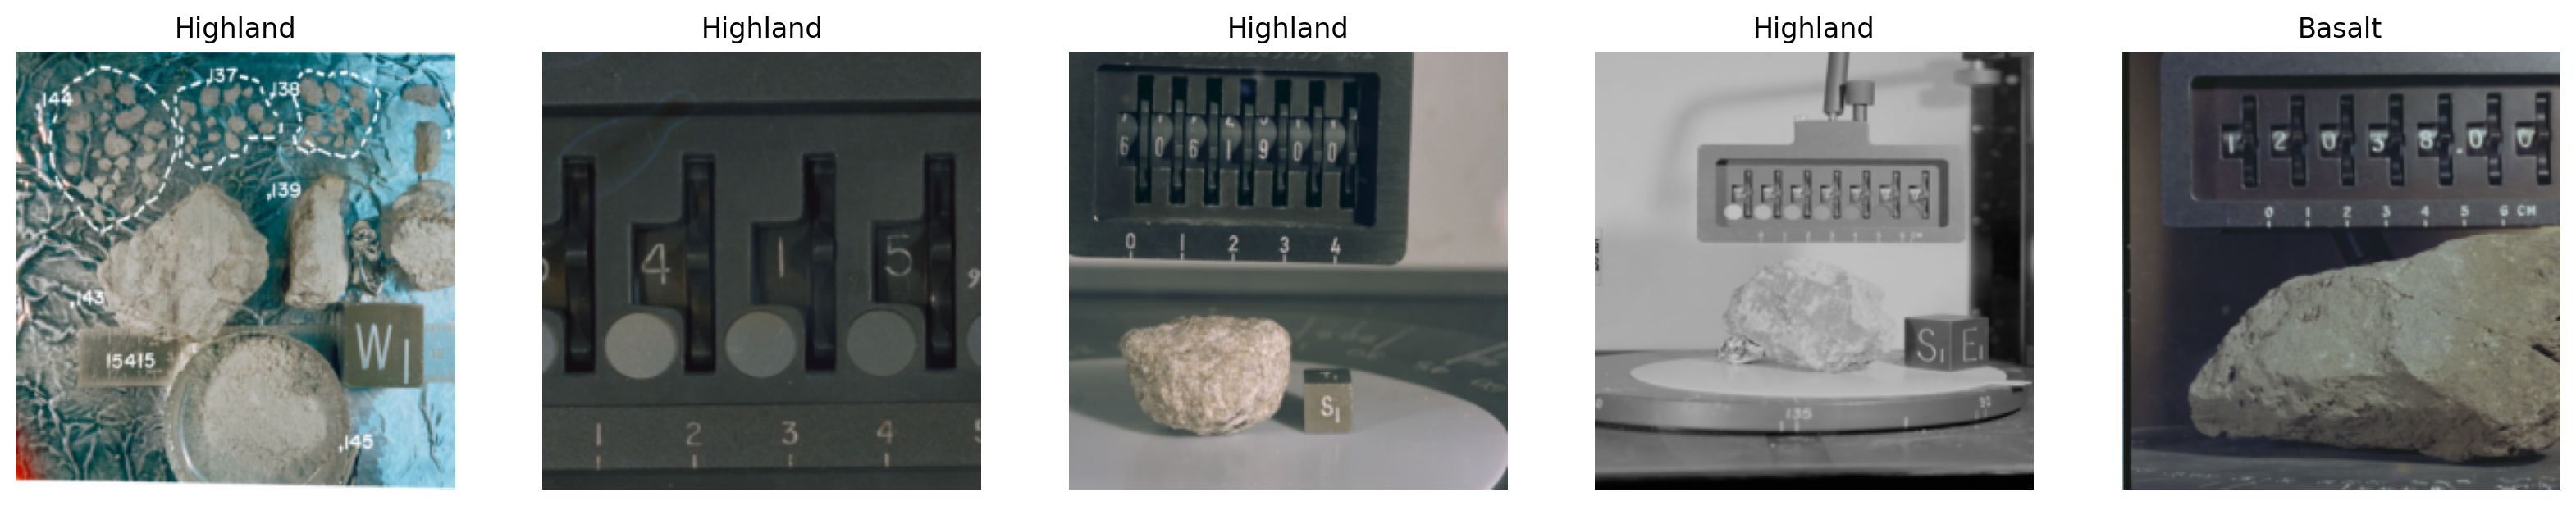

In [129]:
def get_random_images(num) : 
    
    data = datasets.ImageFolder(data_dir, transform=t_transforms)
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]

    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
    #loader에서 데이터를 한 개씩 꺼내 주는 interator 생성
    dataiter = iter(loader)
    images, labels = dataiter.next()

    return images, labels

# 5개의 이미지와 레이블을 랜덤하게 가져온다.
images, labels = get_random_images(5)
# 픽셀 배열을 PIL 형식의 이미지로 변환하고 이미지 크기를 지정한다.
to_pil = transforms.ToPILImage()
fig = plt.figure(figsize=(20,20))
#학습 데이터의 class 리스트를 얻는다.
classes = trainloader.dataset.classes
# 이미지를 표시하기 위한 설정을 한다.
for ii in range(len(images)):
    image = to_pil(images[ii])
    sub = fig.add_subplot(1, len(images), ii+1)
    index = labels[ii].item()
    sub.set_title(classes[index])
    plt.axis('off')
    plt.imshow(image)
# 주피터 노트북에 이미지를 표시한다.
plt.show()



## ResNet50 모델을 가져와 FCL(Fully Connected Layer) 수정
### Compute Device 지정(CPU or GPU)

In [130]:
# compute device를 정하고 확인한다.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


### 사전에 학습된 ResNet50 모델 지정

In [131]:
# resnet50 모델을 pretrained=True로 설정한다.
model = models.resnet50(pretrained=True)

/workspaces/A00-spacerocks/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/workspaces/A00-spacerocks/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### (확인) 수정 전의 ResNet50모델 확인

In [46]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### FCL을 수정한다. (뉴런 구축, 신경망 연결, FCL의 layer 설정 등)

In [132]:
# 모든 신경망 구축 :  전이학습을 위해 모델의 가중치를 freeze 한다.
for param in model.parameters():
    param.requires_grad = False
# 뉴런들을 연결하여 신경망을 생성한다.
model.fc = nn.Sequential(nn.Linear(2048,512),
                         nn.ReLU(),
                         nn.Dropout(0,2),
                         nn.Linear(512,2),
                         nn.LogSoftmax(dim=1))
# 손실함수를 Cross entropy loss 함수로 지정한다.
criterion = nn.NLLLoss()
# optimizer를 Adam으로 지정한다.
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
#신경망을 compute device로 보낸다.
model.to(device)
#종료 여부를 출력한다.
print('done!')

done!


### (확인) FCL 확인

In [48]:
print(model.fc)

Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0, inplace=2)
  (3): Linear(in_features=512, out_features=2, bias=True)
  (4): LogSoftmax(dim=1)
)


## 모델의 FCL을 학습시키고 테스트
### 모델 학습.검증을 위한 변수 설정

In [133]:
# 에폭 및 출력 간격을 설정한다.
epochs = 10
print_every = 5
# 손실 변수들을 초기화 한다.
running_loss = 0
train_losses, test_losses = [], []
# 현재의 학습 단계를 표현하는 steps 변수를 0으로 초기화 한다.
steps = 0

### 설정한 에폭만큼 모델을 학습시키며 검증/평가 한다.

In [134]:
# 설정한 회수만큼 학습 후 테스트 및 평가해 본다.
for epoch in range(epochs) :
    # 에폭을 count 한다.
    epoch += 1
    # trainloader로부터 모든 이미지와 레이블을 로드한다.
    for inputs, labels in trainloader:
        # 학습 단계를 count 하고 출력한다.
        steps += 1
        print('Training step ', steps)
        # 입력 데이터(이미지, 레이블)를 device로 보낸다.
        inputs, labels = inputs.to(device), labels.to(device)
        # 기존에 학습된 gradient 값을 초기화 한다.(이전에 학습한 값이 영향을 주지 않도록 함)
        optimizer.zero_grad()
        # 입력 데이터로 순전파를 수행하고 로그 확률을 얻는다.
        logps = model.forward(inputs)
        # 손실(loss) 값들을 계산한다.
        loss = criterion(logps, labels)
        # 손실값을 이용하여 gradient를 update한다.
        loss.backward()
        # gradient를 이용하여 설정된 optimizer로 파라미터를 update한다.
        optimizer.step()
        # 손실값을 누적/계산한다.
        running_loss += loss.item()
        # 학습 단계 5회마다 모델을 테스트/평가 한다.
        if steps % print_every == 0:
            # 손실과 정확도 변수를 초기화 한다.
            test_loss = 0
            accuracy = 0
            # 모델 평가 모드로 전환한다.
            model.eval()
            # 모델 평가 시 gradient를 계산하지 않도록 한다.
            with torch.no_grad():
                # testloader로부터 모든 이미지와 레이블을 로드한다.
                for inputs, labels in testloader:
                    # 입력 데이터(이미지, 레이블)를 device로 보낸다.
                    inputs, labels = inputs.to(device), labels.to(device)
                    # 입력 데이터로 순전파를 수행하고 로그 확률을 얻는다.
                    logps = model.forward(inputs)
                    # 손실(loss) 값들을 계산한다.
                    batch_loss = criterion(logps, labels)
                    # 손실값을 누적시킨다.
                    test_loss += batch_loss.item()
                    # 로그 확률로부터 진짜 확률값을 계산한다.
                    ps = torch.exp(logps)
                    # 가장 큰 확률값과 class를 얻는다. (topk : k번째로 큰 값)
                    top_p, top_class = ps.topk(1, dim=1)
                    # 레이블들을 top_class와 동일한 형태로 바꾼 후 같은 값들을 얻는다.
                    equals = top_class == labels.view(*top_class.shape)
                    # equals를 float 텐서로 바꾼 후 평균 정확도를 누적/계산한다.
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            # 학습 손실값과 테스트 손실값을 추가한다.
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))
            # 학습 손실값, 테스트 손실값, 테스트 정확도를 출력한다.
            print("Epoch {}/{}: ".format(epoch, epochs),
                  "Train loss: {:.3f}.. ".format(running_loss/print_every),
                  "Test loss: {:.3f}.. ".format(test_loss/len(testloader)),
                  "Test accuracy: {:.3f}\n".format(accuracy/len(testloader))) 
            # running_loss 값을 초기화 한다.
            running_loss = 0
            # 모델 학습 모드로 전환한다.
            model.train()
            break

Training step  1
Training step  2
Training step  3
Training step  4
Training step  5
Epoch 1/10:  Train loss: 2.494..  Test loss: 1.277..  Test accuracy: 0.423

Training step  6
Training step  7
Training step  8
Training step  9
Training step  10
Epoch 2/10:  Train loss: 0.859..  Test loss: 0.616..  Test accuracy: 0.583

Training step  11
Training step  12
Training step  13
Training step  14
Training step  15
Epoch 3/10:  Train loss: 0.456..  Test loss: 0.560..  Test accuracy: 0.808

Training step  16
Training step  17
Training step  18
Training step  19
Training step  20
Epoch 4/10:  Train loss: 0.432..  Test loss: 0.509..  Test accuracy: 0.773

Training step  21
Training step  22
Training step  23
Training step  24
Training step  25
Epoch 5/10:  Train loss: 0.458..  Test loss: 0.409..  Test accuracy: 0.900

Training step  26
Training step  27
Training step  28
Training step  29
Training step  30
Epoch 6/10:  Train loss: 0.318..  Test loss: 0.379..  Test accuracy: 0.808

Training step

### (확인) 학습 손실값과 테스트 손실값을 그래프로 확인

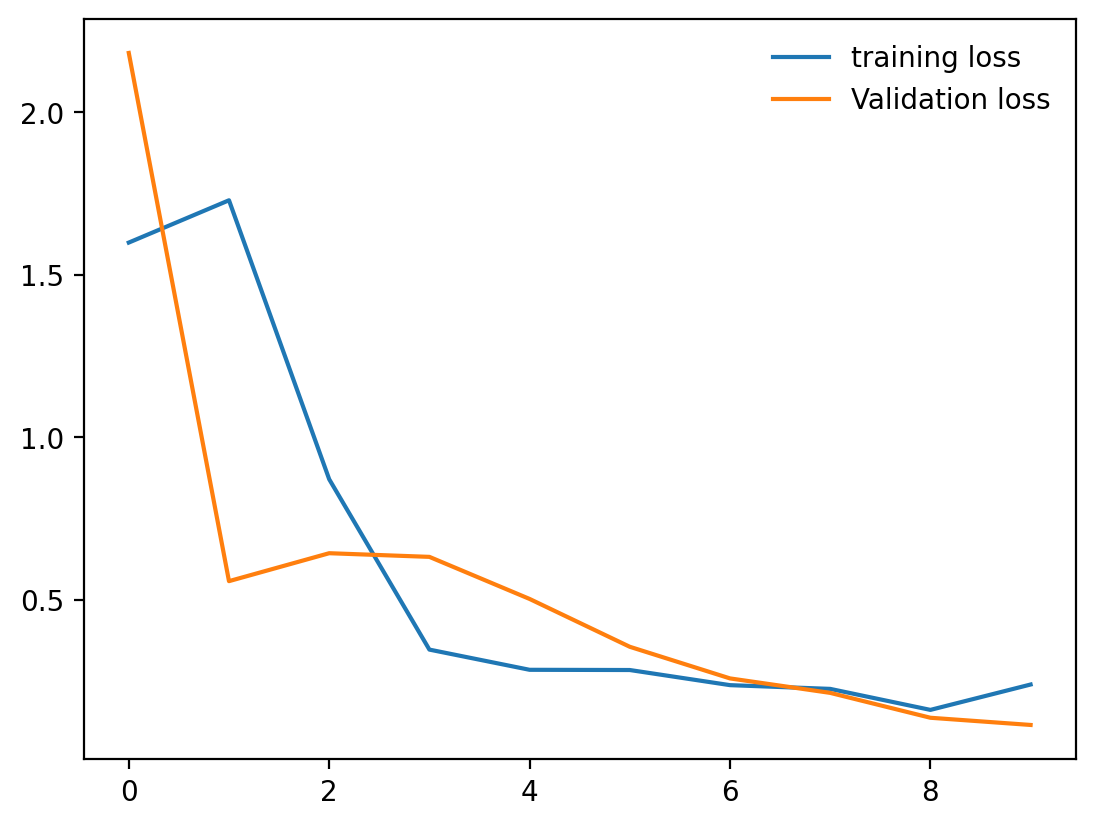

In [51]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## 학습/테스트 완료된 모델 저장

In [52]:
# 추후 로드하여 사용할 수 있도록 학습/테스트 완료된 모델을 저장한다.
torch.save(model,'moonrockmodel.pth')


# 완성된 모델을 사용하여 예측한다.

## 저장한 모델을 불러온다.

In [53]:
# 저장한 모델을 불러온다.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load('moonrockmodel.pth')

In [54]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## 이미지 예측을 위해 predict_image() 함수를 만든다.

In [55]:
def predict_image(image):
    image_tensor = t_transforms(image).float()
    input = image_tensor.unsqueeze_(0)
    input = input.to(device)
    output = model(input)
    index = output.data.numpy().argmax()

    return index

## 5개의 이미지를 임의로 가져와 예측해 본다.

In [56]:
# LCG를 파이썬으로 구현
def lcg(seed, a=1664525, c=1013904223, m=2**32):
    print('input seed : ',seed)
    while True:
        print('2input seed : ', seed)
        seed = (a * seed + c) % m
        print('cal_seed : ',seed)
        yield seed

rgen = lcg(seed=42)
print("첫 번째 난수:", random.randint(1, 100))
print("두 번째 난수:", random.randint(1, 100))

""" for _ in range(5):
    print(next(rgen)) """

첫 번째 난수: 82
두 번째 난수: 15


' for _ in range(5):\n    print(next(rgen)) '

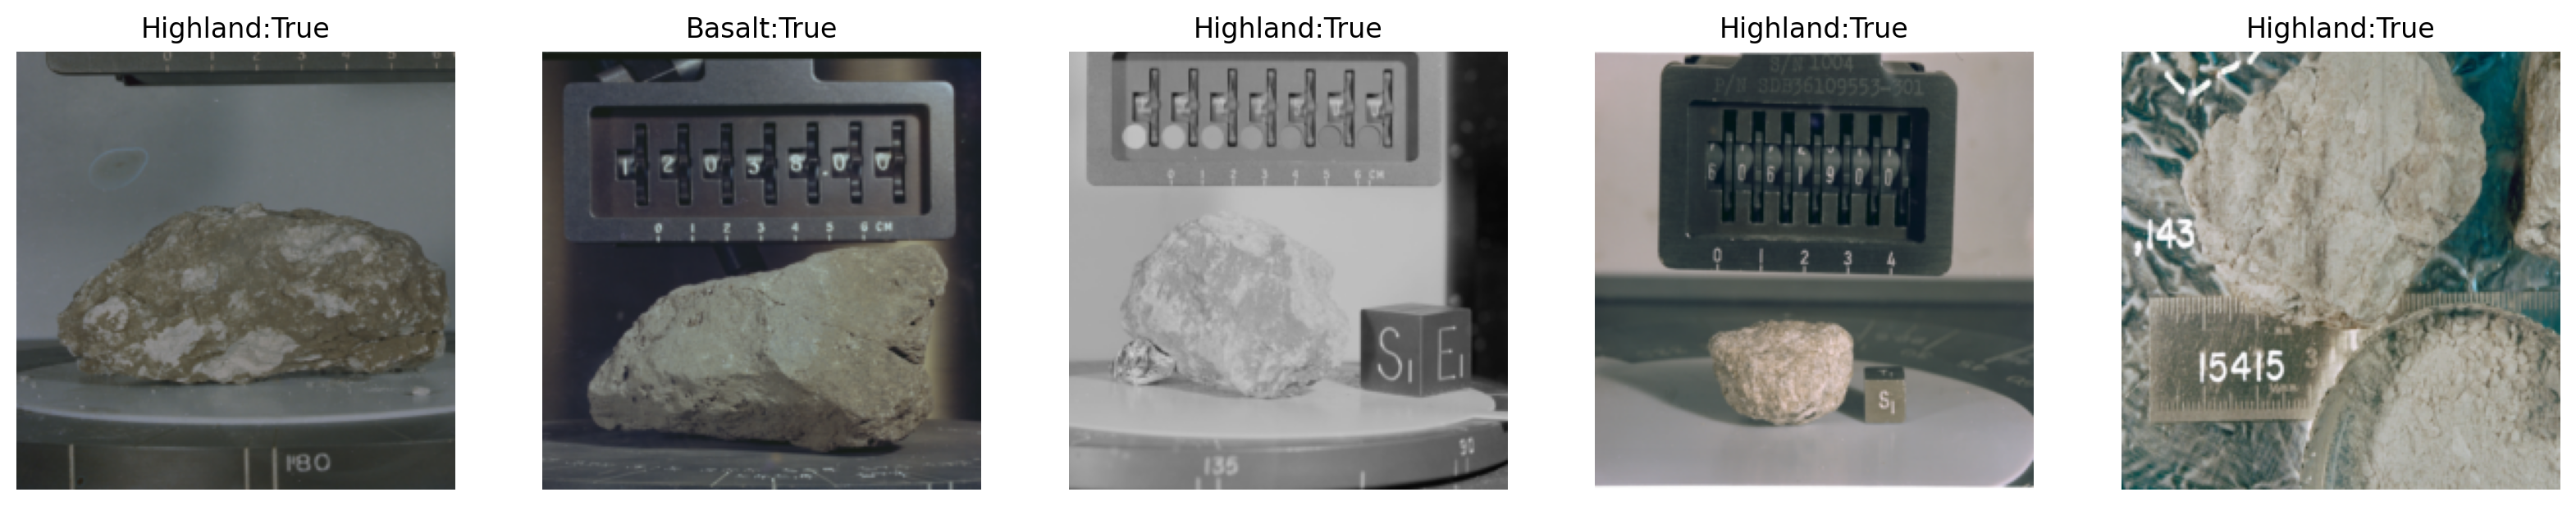

In [57]:
# 모델 평가 모드로 전환한다.
model.eval()
# 5개의 이미지를 랜덤하게 가져온 후 PIL 형식 변환, 표시할 이미지 크기를 설정한다.
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig = plt.figure(figsize=(20, 20))
# 데이터의 class 목록을 얻는다.
classes = trainloader.dataset.classes

# 5개의 이미지에 대해 loop를 수행한다.
for ii in range(len(images)):
    # 각 이미지에 대해 class를 예측한다.
    image = to_pil(images[ii])
    index = predict_image(image)
    # 이미지 아래에 class를 표시하도록 설정한다.
    sub = fig.add_subplot(1, len(images), ii+1)
    res = labels[ii].item() == index
    sub.set_title(classes[index] + ':' + str(res))
    plt.axis('off')
    plt.imshow(image)
# 레이블이 추가된 이미지를 보여준다.
plt.show()